In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [4]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [5]:
import numpy as np
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    Normalize,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)

    mean = [0.45397732, 0.42053542, 0.29964647]
    std = [0.24271463, 0.21145713, 0.21939221]

    if is_train:
        transforms = Compose(
            [
                Resize(*(224, 224, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (train)
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Resize(*(256, 256, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (test)
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image, id) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=128, labeled=True, is_train=True):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        img = transform_image(image=elem[0], is_train=is_train).type(torch.float32)
        lbl = (
            torch.tensor(elem[1].numpy(), dtype=torch.float32)
            if labeled
            else elem[1].numpy().decode("utf-8")
        )
        batch_imgs.append(img)
        batch_lbls.append(lbl)
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls) if labeled else batch_lbls
            batch_imgs, batch_lbls = list(), list()

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [7]:
train_trf_dataset

<generator object load_dataset at 0x7b5b026c7840>

In [8]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "test"), labeled=False)

batch_train_tensors = next(load_tensor_batches(train_trf_dataset, labeled=False, is_train=False))

In [9]:
batch_train_tensors[0].shape

torch.Size([128, 3, 256, 256])

fe75697b0


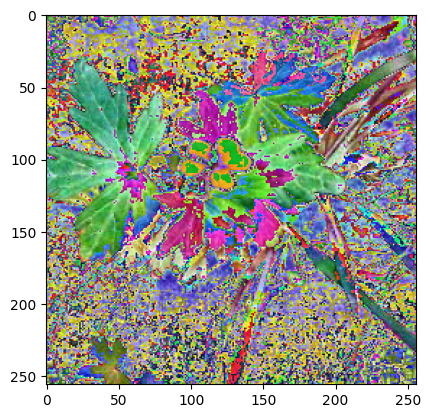

In [14]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [ ]:
xm.get_xla_supported_devices()

In [ ]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

In [15]:
import math

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class xlm_fully_conv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return F.log_softmax(self.model(batch), dim=1)

In [ ]:
xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
output = xlm_model(batch_train_tensors[0].to(device, dtype=torch.float32))

In [ ]:
print(sorted(np.unique(torch.argmax(output, dim=1).detach().cpu().numpy())))

In [17]:
from collections import deque

import torch_xla.distributed.parallel_loader as pl
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


num_epochs = 100
loss = nn.NLLLoss()
batch_size = 512


def train_val_pipeline(i, lock, train_losses, val_losses):
    global num_epochs, loss, batch_size

    device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
    xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
    opt = torch.optim.Adam(xlm_model.parameters(), lr=5e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    rate_tracker_train = xm.RateTracker()
    rate_tracker_val = xm.RateTracker()

    for epoch in range(num_epochs):
        with lock:
            print(f"Epoch: {epoch}")
        xlm_model.train()
        batch_generator_train = load_tensor_batches(
            load_dataset(get_recursive_paths(path, "train")), batch_size, is_train=True
        )
        train_loader = pl.ParallelLoader(batch_generator_train, [device])
        epoch_train_loss = 0

        for iteration, train_batch in enumerate(
            train_loader.per_device_loader(xm.xla_device()), start=1
        ):
            opt.zero_grad()
            with torch_xla.step():
                train_imgs, train_lbls = train_batch[0].to(
                    device, dtype=torch.float32
                ), train_batch[1].to(device, dtype=torch.float32)

                lbls_predict = xlm_model(train_imgs)
                output = loss(lbls_predict, train_lbls)
                output.backward()
                xm.optimizer_step(opt)

                epoch_train_loss += output.item()
                rate_tracker_train.add(batch_size)

                if iteration % 10 == 0:
                    f1 = metrics.f1_score(
                        train_lbls.detach().cpu().numpy(),
                        torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                        average="macro",
                    )
                    with lock:
                        train_losses.append(epoch_train_loss / iteration)
                        print(f"Loss: {output.detach().cpu()}")
                        print(f"F1-score: {f1}")
                        print(f"Rate: {rate_tracker_train.rate()} examples/sec")

            xm.mark_step()

        xlm_model.eval()
        batch_generator_val = load_tensor_batches(
            load_dataset(get_recursive_paths(path, "val")), batch_size, is_train=False
        )
        val_loader = pl.ParallelLoader(batch_generator_val, [device])
        losses, f1scores = deque(), deque()
        epoch_val_loss = 0

        for iteration, val_batch in enumerate(
            val_loader.per_device_loader(xm.xla_device()), start=1
        ):
            with torch_xla.step():
                val_imgs, val_lbls = val_batch[0].to(device, dtype=torch.float32), val_batch[1].to(
                    device, dtype=torch.float32
                )

                with torch.no_grad():
                    lbls_predict = xlm_model(val_imgs)
                    output = loss(lbls_predict, val_lbls)
                    score = metrics.f1_score(
                        val_lbls.detach().cpu().numpy(),
                        torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                        average="macro",
                    )

                    losses.append(output.detach().cpu())
                    f1scores.append(score)
                    rate_tracker_val.add(batch_size)

                    epoch_val_loss += output.item()

            xm.mark_step()

        val_losses.append(epoch_val_loss / iteration)

        scheduler.step(np.mean(np.array(losses)))

        with lock:
            print(f"Validation")
            print(f"Loss: {np.mean(np.array(losses))}")
            print(f"F1-score: {np.mean(np.array(f1scores))}")
            print(f"Rate: {rate_tracker_val.rate()} examples/sec")

In [18]:
import multiprocessing as mp
from multiprocessing import Array

import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp


lock = mp.Manager().Lock()
train_losses, val_losses = mp.Manager().list(), mp.Manager().list()

try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

if __name__ == "__main__":
    xmp.spawn(train_val_pipeline, args=(lock, train_losses, val_losses), start_method="fork")

already done
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Loss: 4.062628269195557
F1-score: 0.009761209175333505
Rate: 38.89337907741482 examples/sec
Loss: 4.027420520782471
F1-score: 0.01025632447280075
Rate: 38.86881106598029 examples/sec
Loss: 4.026167869567871
F1-score: 0.01736325970637261
Rate: 35.32862047099245 examples/sec
Loss: 4.105298042297363
F1-score: 0.01004957892382138
Rate: 35.31300427374634 examples/sec
Loss: 4.055276870727539
F1-score: 0.0106677790446887
Rate: 32.34805695792836 examples/sec
Loss: 4.060018062591553
F1-score: 0.011743004922747106
Rate: 32.33733227132359 examples/sec
Loss: 4.078308582305908
F1-score: 0.011091856725937814
Rate: 29.685229870851845 examples/sec
Loss: 4.088533401489258
F1-score: 0.012214380549734253
Rate: 29.674903149947866 examples/sec
Loss: 3.638204336166382
F1-score: 0.026456952758507863
Rate: 76.22061457709384 examples/sec
Loss: 3.6973354816436768
F1-score: 0.015722101216281
Rate: 151.80161803842574 examples/sec

KeyboardInterrupt: 

Loss: 3.170513391494751
F1-score: 0.060106546030537486
Rate: 112.30292285368154 examples/sec
Loss: 3.200801372528076
F1-score: 0.061035615665084614
Rate: 109.83389401830851 examples/sec
Loss: 3.191405773162842
F1-score: 0.05585873130023589
Rate: 109.59939100878223 examples/sec
Loss: 3.165736198425293
F1-score: 0.06631363575063808
Rate: 109.85316139012835 examples/sec
Loss: 3.1699161529541016
F1-score: 0.05994267608749268
Rate: 110.23908968986828 examples/sec
Loss: 3.2089011669158936
F1-score: 0.045420274042959986
Rate: 111.43969883372964 examples/sec
Loss: 3.2074737548828125
F1-score: 0.07032196226129397
Rate: 110.18266372759865 examples/sec
Loss: 3.1959762573242188
F1-score: 0.05199139828151377
Rate: 109.50785428251211 examples/sec
Validation
Loss: 3.0875298976898193
F1-score: 0.06002215456789412
Rate: 24.29002243529543 examples/sec
Epoch: 3
Validation
Loss: 2.9938886165618896
F1-score: 0.07179232500301912
Rate: 24.283713522379117 examples/sec
Epoch: 3
Validation
Loss: 2.9797451496124

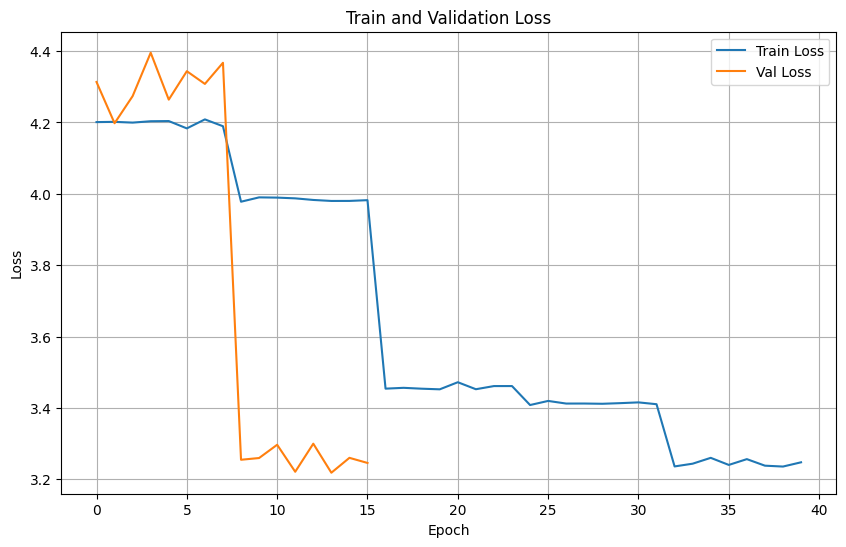

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_losses), label="Train Loss")
plt.plot(list(val_losses), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [21]:
from collections import defaultdict


xlm_model.eval()
test_data = next(
    load_tensor_batches(
        load_dataset(get_recursive_paths(path, "test"), labeled=False),
        batch_size=1,
        labeled=False,
        is_train=False,
    )
)

test_imgs, test_filename = test_data[0].to(device, dtype=torch.float32), test_data[1]
lbls_predict = xlm_model(test_imgs)

print(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()), test_filename)

NameError: name 'xlm_model' is not defined

In [ ]:
from collections import defaultdict

import pandas as pd


xlm_model.eval()
test_data = load_tensor_batches(
    load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
)
test_dataframe = defaultdict(list)

for i, test_batch in enumerate(test_data):
    test_imgs, test_filename = test_batch[0].to(device, dtype=torch.float32), test_batch[1]
    lbls_predict = xlm_model(test_imgs)
    test_dataframe["id"].append(*test_filename)
    test_dataframe["label"].append(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()))

In [ ]:
solution = pd.DataFrame(test_dataframe).reset_index(drop=True)

In [ ]:
solution.head(5)

In [ ]:
solution.to_csv(f"conv_baseline_solution.csv", index=False)